In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.metrics as sklm

In [2]:
def confusion_matrix(true,pred,labels):
    """ Takes the true and predicted labels and creates a confusion matrix
    annoted with the percent of true values classified in each label"""
    # make a confusion matrix
    cfsn_matrix = sklm.confusion_matrix(true,pred)    
    # determine the distribution of true labels as percentage
    percentage = []
    for array in cfsn_matrix:
        percentage.append((array/np.sum(array))*100)
    # heatmap!
    sns.heatmap(percentage,
            annot=percentage,
            fmt='.0f',
            cmap='viridis',
            cbar=False,
            square=True,
            xticklabels = labels,
            yticklabels = labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
def merge_predictions(predict,labels):
    """ Merges the genders and emotions, returns a new dataframe with only 
    the six emotions """
    pred_merge = []
    true_merge = []
    for entry in range(len(predict)):
        if predict.iloc[entry]['predict_int'] > 5:
            pred_merge.append(predict.iloc[entry]['predict_int']-6)
        if predict.iloc[entry]['true_int'] > 5:
            true_merge.append(predict.iloc[entry]['true_int']-6)
        if predict.iloc[entry]['predict_int'] <= 5:
            pred_merge.append(predict.iloc[entry]['predict_int'])
        if predict.iloc[entry]['true_int'] <= 5:
            true_merge.append(predict.iloc[entry]['true_int'])
    # change labels
    labels = predict.columns[:len(predict['true_int'].unique())]
    labels = [emotion[:-5] for emotion in labels[:6]]
    # return merged predictions and new labels
    return pd.DataFrame({'true_int':true_merge,'predict_int':pred_merge}), labels
    
def see_predictions(path,print_fscore=True,merge=False):
    """ take a path and returns a dataframe of scores and displays a 
    confusion matrix."""
    # load csv and extract emotion lables
    predict = pd.read_csv(path,index_col='Unnamed: 0')
    labels = predict.columns[:len(predict['true_int'].unique())]
    # merge the genders if specified
    if merge == True:
        predict, labels = merge_predictions(predict,labels)
    # make a dataframe containing the scores for each emotion
    scores = pd.DataFrame(sklm.precision_recall_fscore_support(predict['true_int'],predict['predict_int']),
                          index=['precision','recall','fscore','total_entries'],
                          columns=labels).T
    scores = scores.append(pd.Series(scores.mean(),name='average'))
    scores = scores.round(2)
    scores = scores.drop(columns=['total_entries'])
    # print the scores if you want
    if print_fscore==True:
        print('average fscore:',scores.loc['average']['fscore'])
    # call the confusion matrix def    
    confusion_matrix(predict['true_int'],predict['predict_int'],labels)
    return(scores)

def compare(left_table,right_table,compare=True,lsuffix='left',rsuffix='right'):
    """ joins two datasets and either returns the join or, if specified, a comparison 
    of each column with left - right """
    # join the two tables
    scores = left_table.join(right_table, lsuffix=lsuffix, rsuffix=rsuffix)
    # return based on specified column
    if compare == True:
        comparison = pd.DataFrame()
        for column in ['precision','recall','fscore']:
            comparison[column]=scores[column+lsuffix] - scores[column+rsuffix]
        return comparison
    else:
        return scores

In [3]:
# this is just so I can easily copy and paste the right path
for file in os.listdir('Data/CSVs/'):
    if 'Predictions' in file:
        print("'Data/CSVs/"+file+"'")

'Data/CSVs/Predictions_Avg_Pool.csv'
'Data/CSVs/Predictions_Avg_Pool_Split.csv'
'Data/CSVs/Predictions_Max_Pool.csv'
'Data/CSVs/Predictions_Max_Pool_Split.csv'


# Average Pooling v Max Pooling

average fscore: 0.57
average fscore: 0.55


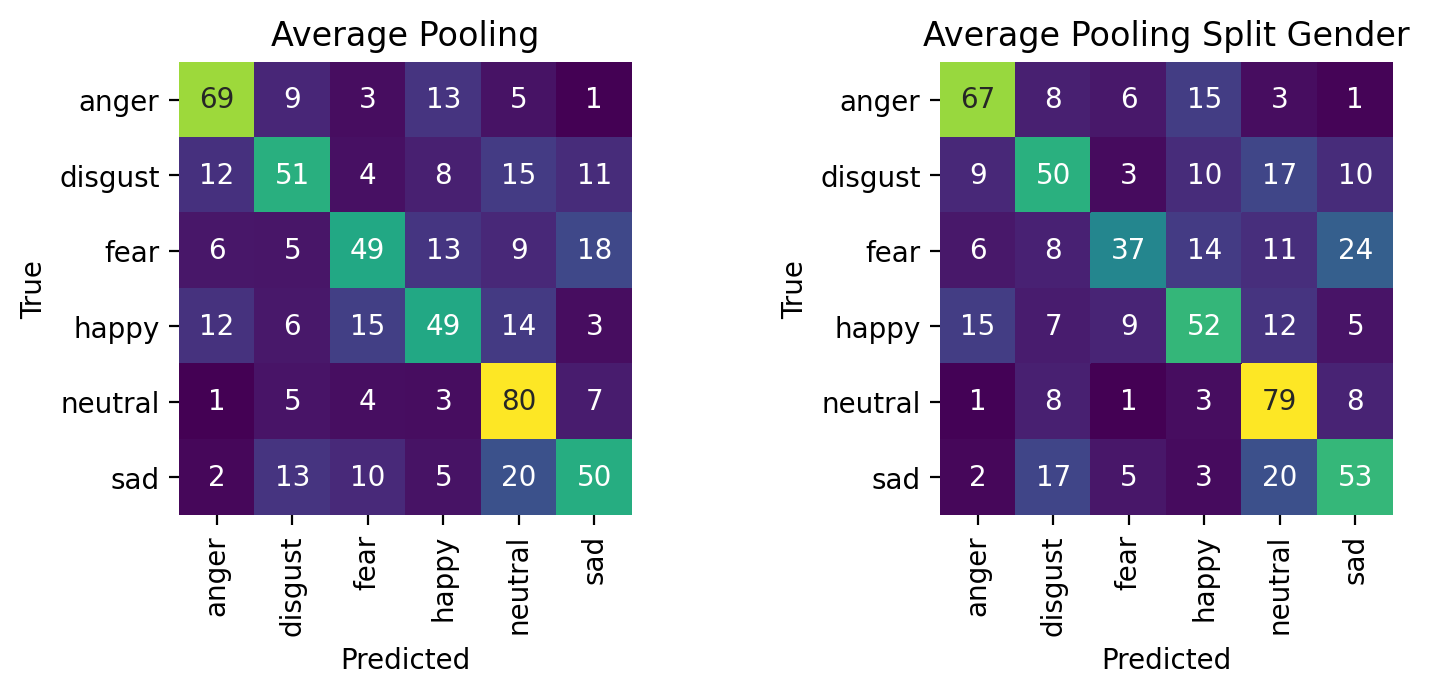

In [4]:
plt.figure(figsize=(9,3),dpi=200)

plt.subplot(121)
MXP = see_predictions('Data/CSVs/Predictions_Avg_Pool.csv')
plt.title('Average Pooling')

plt.subplot(122)
MXP_G = see_predictions('Data/CSVs/Predictions_Avg_Pool_split.csv',merge=True)
plt.title('Average Pooling Split Gender');

In [5]:
score = compare(MXP,MXP_G,lsuffix='_MXP',rsuffix='_MXP_G')
# Positive means MXP > MXP_G
score

,precision,recall,fscore
anger,0.01,0.02,0.01
disgust,0.05,0.01,0.03
fear,-0.04,0.12,0.08
happy,0.01,-0.03,-0.01
neutral,0.01,0.01,0.01
sad,0.04,-0.03,0.01
average,0.02,0.02,0.02


It seems that, in general, the average pooling model (AVP) scores higher than the max pooling model (MXP). The AVP is better at identifying `disgust` and `fear`, while MXP seems to be slighly better at identifying `happy` and `sad`.

The most common errors seen:
- labeling `happy` as `anger` (MXP had this reversed)
- labeling `sad` and `disgust` as `neutral`
- labeling `fear` as `sad`

# Max Pooling

average fscore: 0.56
average fscore: 0.56


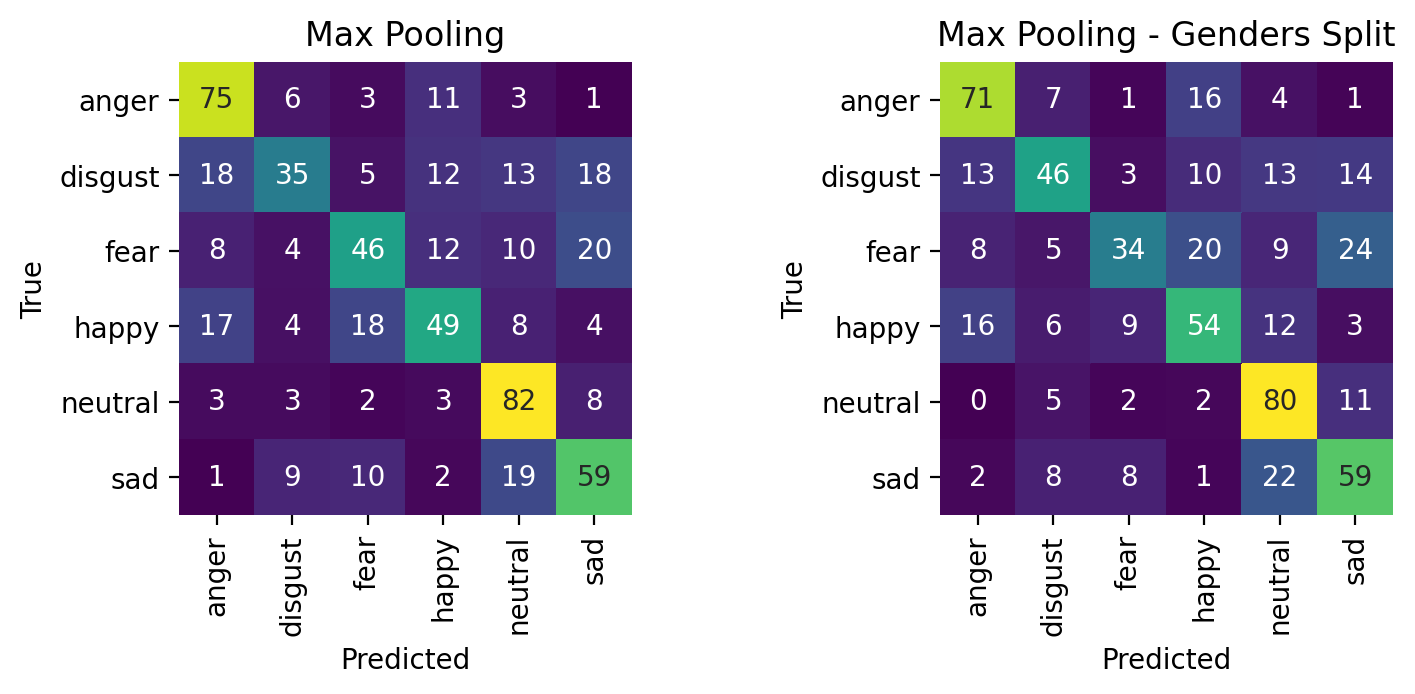

In [6]:
plt.figure(figsize=(9,3),dpi=200)

plt.subplot(121)
MXP = see_predictions('Data/CSVs/Predictions_Max_Pool.csv')
plt.title('Max Pooling')

plt.subplot(122)
MXP_G = see_predictions('Data/CSVs/Predictions_Max_Pool_Split.csv',merge=True)
plt.title('Max Pooling - Genders Split');

In [7]:
score = compare(MXP,MXP_G,lsuffix='_MXP',rsuffix='_MXP_G')
score

,precision,recall,fscore
anger,-0.02,0.04,0.00
disgust,-0.03,-0.11,-0.10
fear,-0.04,0.12,0.07
happy,0.02,-0.05,-0.01
neutral,0.03,0.02,0.03
sad,0.01,0.00,0.01
average,0.00,0.01,0.00


average fscore: 0.52
average fscore: 0.53


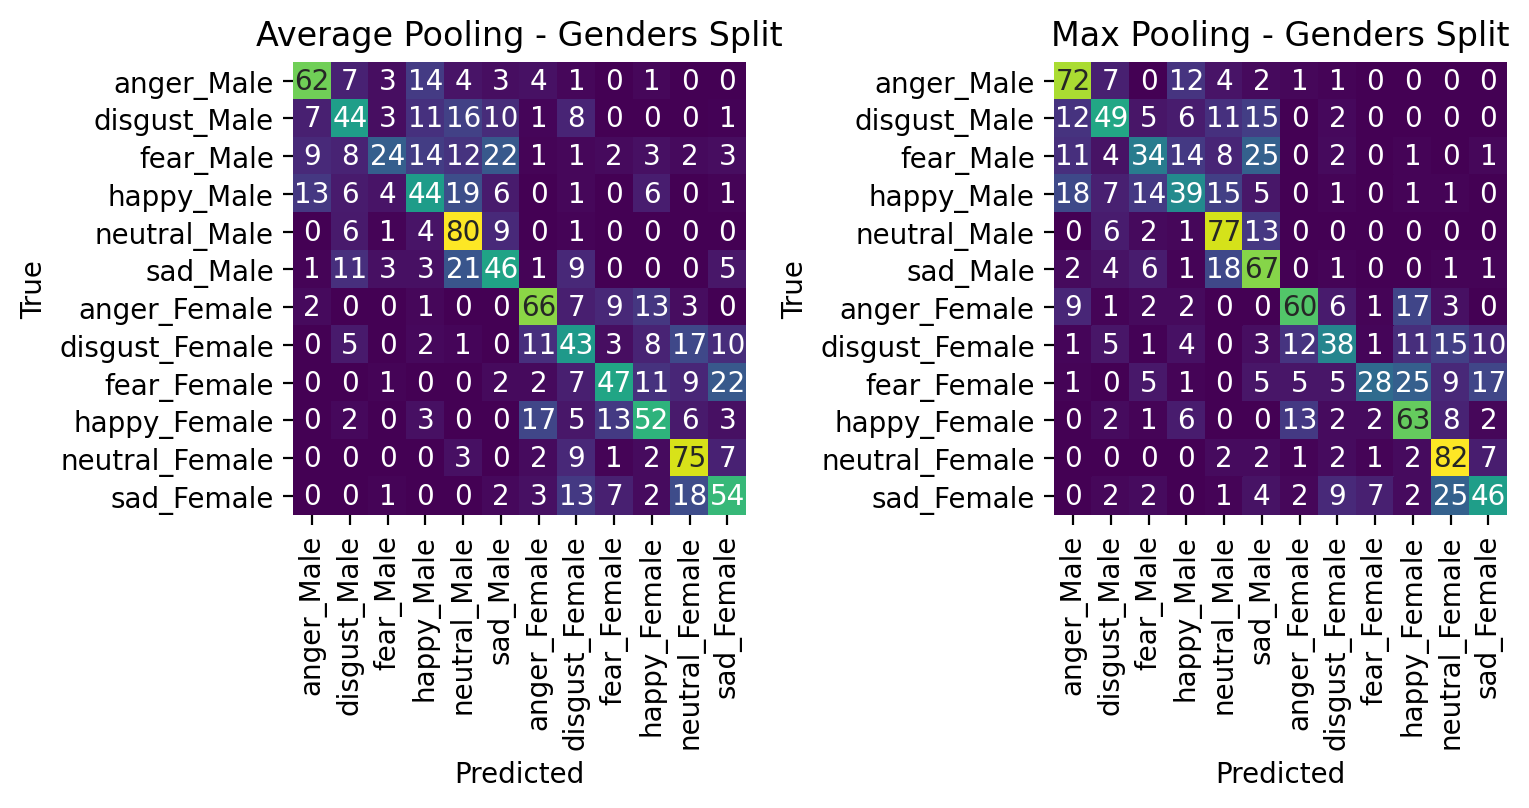

In [9]:
plt.figure(figsize=(9,3),dpi=200)

plt.subplot(121)
see_predictions('Data/CSVs/Predictions_Avg_Pool_Split.csv')
plt.title('Average Pooling - Genders Split')

plt.subplot(122)
see_predictions('Data/CSVs/Predictions_Max_Pool_Split.csv')
plt.title('Max Pooling - Genders Split');